In [1]:
import os
import ctypes
import pickle
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import jit, njit, prange
from numba.extending import get_cython_function_address
from scipy.stats import pearsonr, skew, kurtosis, pointbiserialr, mode, pearsonr, t
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Suppress scientific notation for floats
np.set_printoptions(suppress=True)

In [2]:
try:
    import levy_noise
    
    # Get a pointer to the C function levy.c
    addr_levy = get_cython_function_address("levy_noise", "levy_noise")
    functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double, ctypes.c_double)
    levy_noise = functype(addr_levy)
    print("C implementation accessible.")
    
except Exception as e:
    print("C implementation not accessible, using Python implementation.", str(e))
    
    def random_exponential(mu):
        """Generate a random exponential value."""
        u = np.random.uniform()
        return -mu * np.log1p(-u)

    def random_levy(c, alpha):
        """Generate a random Lévy-distributed value based on the specified parameters."""
        u = np.pi * (np.random.uniform() - 0.5)
        v = 0.0
        while v == 0:
            v = random_exponential(1)

        if alpha == 1.0:
            t = np.tan(u)
            return c * t
        elif alpha == 2.0:
            t = 2 * np.sin(u) * np.sqrt(v)
            return c * t
        else:
            t = np.sin(alpha * u) / (np.cos(u)**(1 / alpha))
            s = (np.cos((1 - alpha) * u) / v)**((1 - alpha) / alpha)
            return c * t * s
        
    def levy_noise(alpha, dt):
        """Simulate noise based on Lévy stable process."""
        rhs = (dt)**(1. / alpha) 
        c = 1. / np.sqrt(2)
        return rhs*random_levy(c, alpha)

C implementation accessible.


In [3]:
@njit
def diffusion_trial(zr, a, v, t0, alpha):
    """
    Parameters:
    - zr (float): Relative starting point.
    - a (float): Threshold separation.
    - v (float): Drift rate.
    - t0 (float): Nondecision time.
    - alpha (float): Stability parameter.

    Returns:
    - float: The reaction time for the trial. Positive for correct decisions, 
      negative for incorrect, and zero for timeouts.
    """
    n_steps = 0.0 
    dt=0.001
    max_steps=10000
    
    x = a * zr

    while (x > 0 and x < a and n_steps < max_steps):
        x += v*dt + levy_noise(alpha, dt)
        n_steps += 1.0

    rt = n_steps * dt 
    rt = rt + t0 if x > 0 else -rt - t0
    
    return rt

@njit
def eam_simulator(zr, a, v, t0, alpha, n_trials):
    """
    Parameters:
    - zr (float): Relative starting point.
    - a (float): Threshold separation.
    - v (float): Drift rate.
    - t0 (float): Nondecision time.
    - alpha (float): Stability parameter.
    - n_trials (int): Number of trials to simulate.

    Returns:
    - tuple: A tuple containing three lists: reaction times for correct decisions, 
    and reaction times for incorrect decisions.
    """
    RTs_correct = []
    RTs_incorrect = []
    for i in range(n_trials):
        rt = diffusion_trial(zr, a, v, t0, alpha)
        if rt>0:
            RTs_correct.append(rt)
        elif rt<0:
            RTs_incorrect.append(-rt)
    return RTs_correct, RTs_incorrect

In [4]:
def load_data(filename):
    """ Load existing data from a pickle file or initialize if file does not exist. """
    if os.path.exists(filename):
        try:
            with open(filename, 'rb') as f:
                data = pickle.load(f)
                if isinstance(data, list):
                    return data
                else:
                    print("Warning: Data corrupted or in unexpected format, starting anew.")
                    return []
        except Exception as e:
            print(f"Error loading data: {e}")
            return []
    return []

def save_data(filename, data):
    """ Save data to a pickle file. """
    try:
        with open(filename, 'wb') as f:
            pickle.dump(data, f)
    except Exception as e:
        print(f"Error saving data: {e}")

In [5]:
def apa_tick_formatter(digits=1):
    def formatter(x, _):
        if x == int(x):
            return str(int(x))
        else:
            return f'{x:.{digits}f}'.lstrip('0') 
    return formatter 

In [6]:
def blend_with_white(color, alpha=0.5):
    original_color = mcolors.to_rgb(color)
    white = (1, 1, 1) 
    blended_color = [alpha * oc + (1 - alpha) * w for oc, w in zip(original_color, white)]
    return mcolors.to_hex(blended_color)

palette = ["#6B6B6B", "#6A33A2", "teal"]
palette_dict = {
    "Highly Positively Skewed": palette[0],
    "Moderately Positively Skewed": palette[1],
    "Nearly Symmetrical": palette[2]
}
alpha_value = 0.75
palette_dict = {key: blend_with_white(color, alpha=alpha_value) for key, color in palette_dict.items()}
palette = list(palette_dict.values())

marker_alpha = 0.15
overall_marker_color = "#456ec4" #'#073eb0'

my_font_size = 12
my_dpi = 200

# Check Functions

In [7]:
diffusion_trial(zr=0.5, a=1, v=2, t0=0.5, alpha=1.5)

1.01

In [8]:
eam_simulator(zr=0.5, a=1, v=2, t0=0.5, alpha=1.5, n_trials=10)

([0.895, 0.651, 0.615, 0.714, 0.581, 0.656, 0.563, 0.75, 0.598, 0.655], [])

# Set Constants

In [9]:
a_values = [1.20-0.47, 1.20, 1.20+0.47]
v_values = [3.15-1.25, 3.15, 3.15+1.25]
t0_values = [0.25-0.04, 0.25, 0.25+0.04]
alpha_values =  [round(1 + i * 0.05, 2) for i in range(int((2 - 1) / 0.05 + 1))]

print("Threshold separation values:", a_values)
print("Drift rate values:", v_values)
print("Nondecision time values:", t0_values)
print("Alpha values:", alpha_values)

Threshold separation values: [0.73, 1.2, 1.67]
Drift rate values: [1.9, 3.15, 4.4]
Nondecision time values: [0.21, 0.25, 0.29]
Alpha values: [1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0]


In [10]:
n_combinations = len(a_values) * len(v_values) * len(t0_values) * len(alpha_values)
n_trials = 400
rounds_per_combination = 1

print("Number of combinations:", n_combinations)
print("Number of simulation per combination:", rounds_per_combination)
print("Total number of simulations:", n_combinations*rounds_per_combination)

Number of combinations: 567
Number of simulation per combination: 1
Total number of simulations: 567


In [11]:
filename = 'simulate_alpha_behavior.pkl'
if os.path.exists(filename):
    data = load_data(filename)
    start_index = len(data)
else:
    data = []
    start_index = 0
print(start_index, "sim available.")

1 sim available.


# Simulation

In [12]:
for i in range(start_index, rounds_per_combination):
    trial_data = []
    for alpha in tqdm(alpha_values, desc=f"Processing round {i + 1}"):
        for a in a_values:
            for v in v_values:
                for t0 in t0_values:
                    RTs_correct, RTs_incorrect = eam_simulator(0.5, a, v, t0, alpha, n_trials)
                    RTs_correct = np.array(RTs_correct, dtype=np.float64)
                    RTs_incorrect = np.array(RTs_incorrect, dtype=np.float64)
                    stats_data = {
                        'index': i+1,
                        'alpha': alpha, 'v': v, 'a': a, 't0': t0,
                        'accuracy': RTs_correct.size/n_trials,
                        'meanRT_correct': np.mean(RTs_correct) if RTs_correct.size else None,
                        'skewness_correct': skew(RTs_correct, bias=False) if RTs_correct.size > 2 else None,
                        'meanRT_incorrect': np.mean(RTs_incorrect, bias=False) if RTs_incorrect.size else None,
                        'skewness_incorrect': skew(RTs_incorrect) if RTs_incorrect.size > 2 else None,
                        'RTs_correct': RTs_correct,
                        'RTs_incorrect': RTs_incorrect
                    }
                    trial_data.append(stats_data)
    data.append(trial_data)
    save_data(filename, data)

print("Simulation completed.")

Simulation completed.


In [13]:
data = load_data(filename)
flattened_data = [item for sublist in data for item in sublist]
df = pd.DataFrame(flattened_data)
print(len(df))

567


In [14]:
df

,index,alpha,v,a,t0,accuracy,meanRT_correct,skewness_correct,meanRT_incorrect,skewness_incorrect,RTs_correct,RTs_incorrect
0,1,1.0,1.90,0.73,0.21,0.9050,0.400152,2.060195,0.310316,1.620051e+00,"[0.378, 0.324, 0.325, 0.329, 0.329, 0.487, 0.3...","[0.33399999999999996, 0.251, 0.532, 0.611, 0.3..."
1,1,1.0,1.90,0.73,0.25,0.9325,0.437434,1.470146,0.361630,5.040952e-01,"[0.41900000000000004, 0.42000000000000004, 0.3...","[0.255, 0.405, 0.445, 0.397, 0.368, 0.519, 0.2..."
2,1,1.0,1.90,0.73,0.29,0.9075,0.476810,0.980881,0.412189,1.923939e+00,"[0.44199999999999995, 0.49, 0.486, 0.428, 0.41...","[0.308, 0.43499999999999994, 0.325999999999999..."
3,1,1.0,3.15,0.73,0.21,0.9475,0.327121,1.351026,0.272476,9.588920e-01,"[0.34299999999999997, 0.45199999999999996, 0.3...","[0.244, 0.241, 0.34299999999999997, 0.235, 0.2..."
4,1,1.0,3.15,0.73,0.25,0.9500,0.362487,1.016876,0.313850,3.331840e-01,"[0.477, 0.358, 0.397, 0.426, 0.358, 0.34199999...","[0.333, 0.269, 0.325, 0.355, 0.273, 0.367, 0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...
562,1,2.0,3.15,1.67,0.25,1.0000,0.513883,1.394826,NaN,NaN,"[0.618, 0.365, 0.633, 0.42400000000000004, 0.4...",[]
563,1,2.0,3.15,1.67,0.29,0.9850,0.548919,1.690479,0.504833,1.273568e+00,"[0.45799999999999996, 0.39599999999999996, 0.5...","[0.501, 0.472, 0.412, 0.46299999999999997, 0.6..."
564,1,2.0,4.40,1.67,0.21,0.9950,0.404209,1.192097,0.362000,1.466256e-15,"[0.32, 0.397, 0.33999999999999997, 0.385, 0.28...","[0.306, 0.41800000000000004]"
565,1,2.0,4.40,1.67,0.25,0.9925,0.448947,1.275525,0.414000,-2.091129e-01,"[0.40900000000000003, 0.457, 0.427, 0.351, 0.5...","[0.479, 0.34099999999999997, 0.42200000000000004]"


In [15]:
df_cor = df[['index', 'alpha', 'v', 'a', 't0', 
             'accuracy', 
             'meanRT_correct',
             'skewness_correct',
             'meanRT_incorrect',
             'skewness_incorrect',
             'RTs_correct'
            ]].explode('RTs_correct')
df_cor['RT_type'] = 'correct' 
df_cor.rename(columns={'RTs_correct': 'RT'}, inplace=True)

df_incor = df[['index', 'alpha', 'v', 'a', 't0', 
             'accuracy', 
             'meanRT_incorrect',
             'skewness_incorrect',
             'RTs_incorrect']].explode('RTs_incorrect')
df_incor['RT_type'] = 'incorrect'  
df_incor.rename(columns={'RTs_incorrect': 'RT'}, inplace=True)

df_long = pd.concat([df_cor, df_incor])
df_long.reset_index(drop=True, inplace=True)

In [16]:
df_long

,index,alpha,v,a,t0,accuracy,meanRT_correct,skewness_correct,meanRT_incorrect,skewness_incorrect,RT,RT_type
0,1,1.0,1.9,0.73,0.21,0.9050,0.400152,2.060195,0.310316,1.620051e+00,0.378,correct
1,1,1.0,1.9,0.73,0.21,0.9050,0.400152,2.060195,0.310316,1.620051e+00,0.324,correct
2,1,1.0,1.9,0.73,0.21,0.9050,0.400152,2.060195,0.310316,1.620051e+00,0.325,correct
3,1,1.0,1.9,0.73,0.21,0.9050,0.400152,2.060195,0.310316,1.620051e+00,0.329,correct
4,1,1.0,1.9,0.73,0.21,0.9050,0.400152,2.060195,0.310316,1.620051e+00,0.329,correct
...,...,...,...,...,...,...,...,...,...,...,...,...
226796,1,2.0,4.4,1.67,0.21,0.9950,NaN,NaN,0.362000,1.466256e-15,0.418,incorrect
226797,1,2.0,4.4,1.67,0.25,0.9925,NaN,NaN,0.414000,-2.091129e-01,0.479,incorrect
226798,1,2.0,4.4,1.67,0.25,0.9925,NaN,NaN,0.414000,-2.091129e-01,0.341,incorrect
226799,1,2.0,4.4,1.67,0.25,0.9925,NaN,NaN,0.414000,-2.091129e-01,0.422,incorrect


# Correlations

In [17]:
r, p_value = pearsonr(df['alpha'], df['skewness_correct'])
n = len(df)  
degrees_freedom = n - 2     

alpha = 0.05  
t_crit = t.ppf(1 - alpha / 2, degrees_freedom) 
stderr = np.sqrt((1 - r**2) / degrees_freedom)  
delta = t_crit * stderr 

ci_lower = r - delta
ci_upper = r + delta

print(f"Correlation between alpha and correct skewness: r = {r:.2f}, p-value = {p_value:.3f}")

Correlation between alpha and correct skewness: r = 0.40, p-value = 0.000


In [18]:
df_clean = df[['alpha', 'skewness_incorrect']].dropna()

r, p_value = pearsonr(df_clean['alpha'], df_clean['skewness_incorrect'])
n = len(df_clean)  
degrees_freedom = n - 2    

t_crit = t.ppf(1 - alpha / 2, degrees_freedom)  
stderr = np.sqrt((1 - r**2) / degrees_freedom)
delta = t_crit * stderr

ci_lower = r - delta
ci_upper = r + delta

print(f"Correlation between alpha and incorrect skewness: r = {r:.2f}, p-value = {p_value:.3f}")

Correlation between alpha and incorrect skewness: r = -0.05, p-value = 0.279


# Regressions

                            OLS Regression Results                            
Dep. Variable:                 meanRT   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     54.59
Date:                Thu, 22 May 2025   Prob (F-statistic):           5.92e-33
Time:                        17:25:51   Log-Likelihood:                 1046.9
No. Observations:                1133   AIC:                            -2086.
Df Residuals:                    1129   BIC:                            -2066.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2989      0.020     14.609

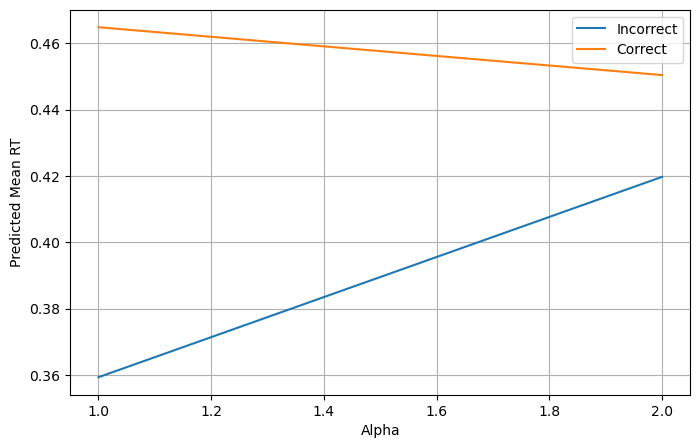

In [19]:
df_reg = df[['alpha', 'meanRT_correct', 'meanRT_incorrect']].copy() 
df_reg_long = df_reg.melt(
    id_vars='alpha',
    value_vars=['meanRT_correct', 'meanRT_incorrect'],
    var_name='correct',
    value_name='meanRT'
)

df_reg_long['correct'] = df_reg_long['correct'].map({
    'meanRT_correct': 1,
    'meanRT_incorrect': 0
})

formula = "meanRT ~ alpha + correct + alpha:correct"
model = smf.ols(formula=formula, data=df_reg_long).fit()

print(model.summary())
alpha_vals = np.linspace(df_reg_long['alpha'].min(), df_reg_long['alpha'].max(), 100)
pred_df = pd.DataFrame({
    'alpha': np.tile(alpha_vals, 2),
    'correct': np.repeat([0, 1], len(alpha_vals))
})
pred_df['meanRT_pred'] = model.predict(pred_df)

plt.figure(figsize=(8, 5))
for c, label in zip([0, 1], ['Incorrect', 'Correct']):
    subset = pred_df[pred_df['correct'] == c]
    plt.plot(subset['alpha'], subset['meanRT_pred'], label=label)

plt.xlabel('Alpha')
plt.ylabel('Predicted Mean RT')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
df['z_v'] = (df['v'] - df['v'].mean()) / df['v'].std()
df['z_a'] = (df['a'] - df['a'].mean()) / df['a'].std()
df['z_t0'] = (df['t0'] - df['t0'].mean()) / df['t0'].std()
df['z_alpha'] = (df['alpha'] - df['alpha'].mean()) / df['alpha'].std()

formula = "skewness_correct ~ alpha + z_v + z_a + z_t0 + alpha:z_v + alpha:z_a + alpha:z_t0"
model = smf.ols(formula=formula, data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       skewness_correct   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     27.66
Date:                Thu, 22 May 2025   Prob (F-statistic):           1.08e-32
Time:                        17:25:51   Log-Likelihood:                -212.13
No. Observations:                 567   AIC:                             440.3
Df Residuals:                     559   BIC:                             475.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6898      0.075      9.174      0.0

In [21]:
formula = "skewness_correct ~ z_alpha + z_v + z_a + z_t0 + alpha:z_v + alpha:z_a + alpha:z_t0"
model = smf.ols(formula=formula, data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       skewness_correct   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     27.66
Date:                Thu, 22 May 2025   Prob (F-statistic):           1.08e-32
Time:                        17:25:51   Log-Likelihood:                -212.13
No. Observations:                 567   AIC:                             440.3
Df Residuals:                     559   BIC:                             475.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5038      0.015    101.078      0.0

# Scatter Plots Parameters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


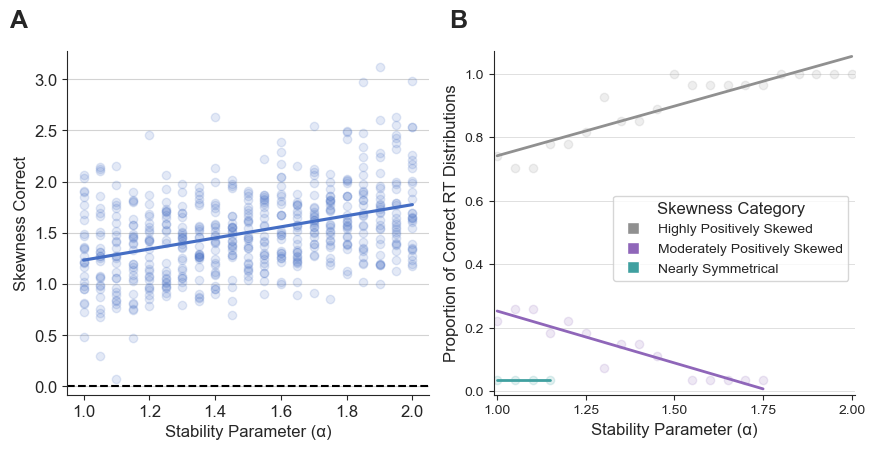

In [22]:
conditions = [
    (df['skewness_correct'] > 1),
    (df['skewness_correct'] > 0.5) & (df['skewness_correct'] <= 1),
    (df['skewness_correct'] > 0) & (df['skewness_correct'] <= 0.5)
]
categories = ['Highly Positively Skewed', 'Moderately Positively Skewed', 'Nearly Symmetrical']

df['skew_category'] = np.select(conditions, categories, default='Other')

proportion_data = (
    df.groupby(['alpha', 'skew_category'], group_keys=False)
    .size()
    .groupby(level=0, group_keys=False)
    .apply(lambda x: x / x.sum())
    .reset_index(name='proportion')
)

sns.set_style("ticks")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))  

# Panel A 
my_font_size = 12

def plot_data_overall(df, palette, stats=['skewness_correct'], ax=None):
    alpha_level = 0.1
    for stat in stats:
        if stat not in df.columns:
            raise ValueError(f"Column '{stat}' not found in the DataFrame")

        sns.regplot(
            x='alpha', y=stat, data=df,
            scatter_kws={'alpha': marker_alpha},
            line_kws={'color': overall_marker_color},
            color=overall_marker_color,
            ax=ax,
            ci=False
        )

        ax.set_title(' ', fontsize=my_font_size + 2)

        if stat == 'skewness_correct':
            ax.set_ylabel('Skewness Correct', fontsize=my_font_size)
        elif stat == 'skewness_incorrect':
            ax.set_ylabel('Skewness Incorrect', fontsize=my_font_size)

        ax.set_xlabel('Stability Parameter (α)', fontsize=my_font_size)
        ax.tick_params(labelsize=my_font_size)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, which='major', axis='y', color='lightgrey')
        ax.axhline(y=0, color='black', linestyle='--')

    ax.legend(
        title=' ',
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=3,
        frameon=False,
        fontsize=my_font_size,
        title_fontsize=my_font_size
    )

plot_data_overall(df, palette, stats=['skewness_correct'], ax=ax1)

# Panel B 
for category in proportion_data['skew_category'].unique():
    subset = proportion_data[proportion_data['skew_category'] == category]
    
    sns.regplot(
        data=subset,
        x='alpha',
        y='proportion',
        scatter=True,  
        line_kws={'linewidth': 2},
        color=palette_dict[category],
        scatter_kws={'alpha': marker_alpha},
        ax=ax2,
        ci=False
    )

ax2.set_title(' ', fontsize=my_font_size + 2)
ax2.set_xlabel('Stability Parameter (α)', fontsize=my_font_size)
ax2.set_ylabel('Proportion of Correct RT Distributions', fontsize=my_font_size)

legend_handles = [
    plt.Line2D([0], [0], marker='s', color='w',
               label=category,
               markerfacecolor=palette_dict[category],
               markersize=8)
    for category in proportion_data['skew_category'].unique()
]

ax2.legend(
    handles=legend_handles,
    title='Skewness Category',
    fontsize=10,
    title_fontsize=12,
    bbox_to_anchor=(1, 0.6)
)

ax2.grid(True, axis='y', color='lightgrey', linestyle='-', linewidth=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.xaxis.set_ticks(np.arange(1, 2.01, 0.25))
ax2.set_xlim(0.99, 2.01)
ax2.set_ylim(-0.01, 1.07)

fig.text(0.0125, 0.95, "A", fontsize=18, ha='left', fontweight='bold')
fig.text(0.5, 0.95, "B", fontsize=18, ha='left', fontweight='bold')

plt.tight_layout(rect=[0, 0, 0.98, 0.98])  

plt.savefig("sim_skew_combined.png", dpi=my_dpi, bbox_inches="tight")
plt.show()

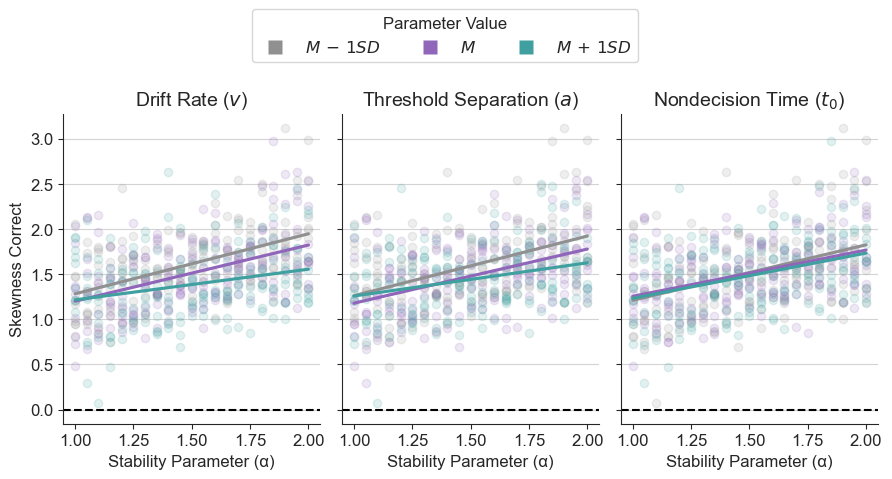

In [23]:
def plot_data(df, category_list, category_values_dict, palette, stats=['skewness_correct']):
    n_rows = len(stats)
    n_cols = len(category_list)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(9, 4.2 * n_rows), sharey='row')

    all_handles = []
    pretty_labels = [r'$M \,-\, 1SD$', r'$M$', r'$M \,+\, 1SD$']

    for row, stat in enumerate(stats):
        for col, category in enumerate(category_list):
            ax = axs[row, col] if n_rows > 1 else axs[col]

            for value, label, color in zip(category_values_dict[category], pretty_labels, palette):
                df_subset = df[df[category] == value]
                sns.regplot(
                    x='alpha', y=stat, data=df_subset,
                    scatter_kws={'alpha': marker_alpha},
                    line_kws={'color': color},
                    color=color,
                    ax=ax,
                    ci=False
                )

                if row == 0 and col == 0:
                    all_handles.append(Line2D(
                        [0], [0],
                        marker='s',
                        color='white',
                        markerfacecolor=color,
                        markeredgecolor='none',
                        markersize=10,
                        label=label
                    ))

            if row == 0:
                if category == 'v':
                    title = 'Drift Rate ($\\it{v}$)'
                elif category == 'a':
                    title = 'Threshold Separation ($\\it{a}$)'
                elif category == 't0':
                    title = 'Nondecision Time ($\\it{t_0}$)'
                else:
                    title = category
                ax.set_title(title, fontsize=my_font_size + 2)

            if row == n_rows - 1:
                ax.set_xlabel('Stability Parameter (α)', fontsize=my_font_size)
            else:
                ax.set_xlabel('')
            
            if col == 0:
                if stat == 'skewness_correct':
                    ax.set_ylabel('Skewness Correct', fontsize=my_font_size)
                elif stat == 'skewness_incorrect':
                    ax.set_ylabel('Skewness Incorrect', fontsize=my_font_size)
            else:
                ax.set_ylabel('')

            ax.tick_params(labelsize=my_font_size)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(True, which='major', axis='y', color='lightgrey')
            ax.axhline(y=0, color='black', linestyle='--')

    fig.legend(
        handles=all_handles,
        title='Parameter Value',
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(pretty_labels),
        frameon=True,
        fontsize=my_font_size,
        title_fontsize=my_font_size
    )

    plt.tight_layout(rect=[0, 0, 1, 0.975])
    plt.savefig(f"sim_skew_mod", dpi=my_dpi, bbox_inches="tight")
    plt.show()
    
category_list = ['v', 'a', 't0']
category_values_dict = {
    'v': v_values,
    'a': a_values,
    't0': t0_values
}
plot_data(df, category_list, category_values_dict, palette)

# Histograms RTs

In [24]:
df_long_specific_alpha = df_long[(df_long['alpha'].isin([1.0, 1.5, 2.0]))]
df_long_specific_alpha = df_long_specific_alpha.copy()
df_long_specific_alpha['RT'] = df_long_specific_alpha['RT'] * 1000

In [25]:
df_long_specific_alpha_corr = df_long_specific_alpha[df_long_specific_alpha['RT_type']=="correct"]
sorted(df_long_specific_alpha_corr['alpha'].unique())

[1.0, 1.5, 2.0]

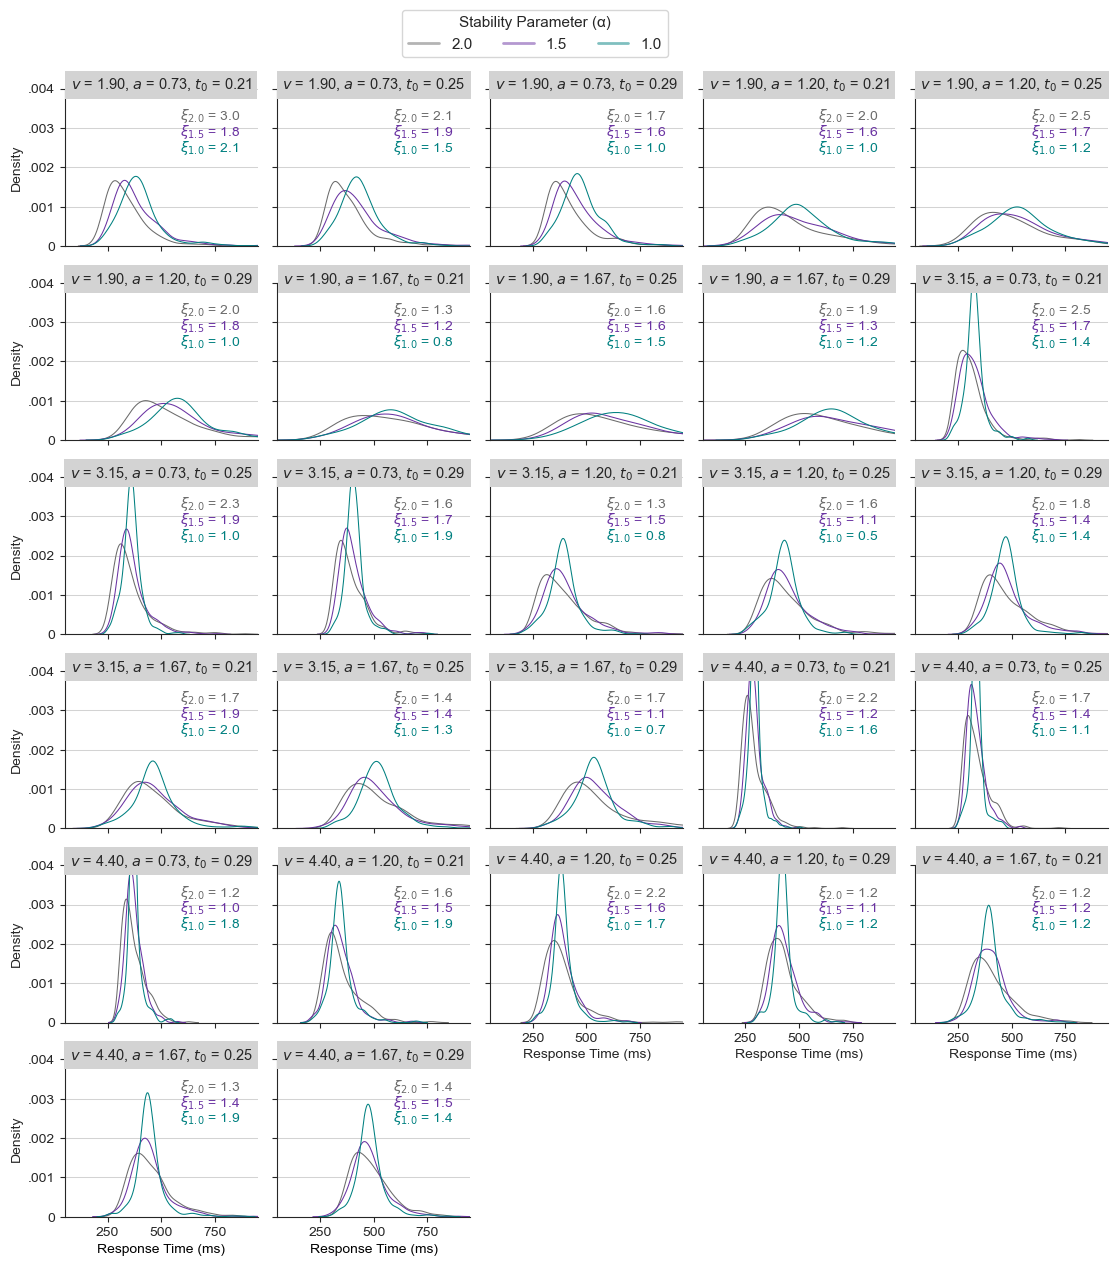

In [26]:
myxlim = 950
myylim = 0.004
palette = ["#6B6B6B", "#6A33A2", "teal"]
palette_dict = {
    2.0: palette[0],
    1.5: palette[1],
    1.0: palette[2]
}

grouped_data = df_long_specific_alpha_corr.groupby(['v', 'a', 't0'])
n_combinations = len(grouped_data)

cols = 5
rows = (n_combinations + cols - 1) // cols
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(2.4*cols, 2.35*rows), sharex=1, sharey=True)
axes = axes.flatten()

for i, ((v, a, t0), group) in enumerate(grouped_data):
    sns.kdeplot(data=group, x='RT', hue="alpha", linestyle='-',
                palette=palette_dict, 
                ax=axes[i], lw=0.75, label="None",
                fill=False, legend=False)

    title_text = f"$v$ = {v:.2f}, $a$ = {a:.2f}, $t_0$ = {t0:.2f}"
    if i in range(22, 25):
        my_y = 1.01
    else:
        my_y =1
    axes[i].set_title(title_text, fontsize=10.5, pad=0, loc='center',
                      bbox=dict(facecolor='lightgrey', edgecolor='none'),
                     y=my_y)
    
    skew_alpha2 = group.loc[group['alpha'] == 2, 'RT'].skew()
    skew_alpha15 = group.loc[group['alpha'] == 1.5, 'RT'].skew()
    skew_alpha1 = group.loc[group['alpha'] == 1, 'RT'].skew()
    
    label2 = f"$\\xi_{{2.0}}$ = {skew_alpha2:.1f}"
    label15 = f"$\\xi_{{1.5}}$ = {skew_alpha15:.1f}"
    label1 = f"$\\xi_{{1.0}}$ = {skew_alpha1:.1f}"

    skew_label_size=10
    start_y = 0.885
    axes[i].text(0.6, 0.885, label2, transform=axes[i].transAxes, fontsize=skew_label_size, verticalalignment='top',
                color=palette[0])
    axes[i].text(0.6, start_y-.1, label15, transform=axes[i].transAxes, fontsize=skew_label_size, verticalalignment='top',
                color=palette[1])
    axes[i].text(0.6, start_y-.2, label1, transform=axes[i].transAxes, fontsize=skew_label_size, verticalalignment='top',
                color=palette[2])

    axes[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.3f}".lstrip("0")))
    axes[i].grid(True, axis='y', color='lightgrey', linestyle='-', linewidth=0.5)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(50, myxlim)
    ax.set_ylim(0, myylim)
    ax.grid(True, axis='y', color='lightgrey', linestyle='-', linewidth=0.75, zorder=0)
    ax.yaxis.set_major_formatter(FuncFormatter(apa_tick_formatter(digits=3)))
    ax.set_xlabel("Response Time (ms)", color="black")  

for ax in axes[22:25]:
    ax.tick_params(labelbottom=True)

fig.tight_layout(rect=[0.05, 0.05, 0.99, 0.908]) 

handles = [
    Line2D([], [], color=palette[0], lw=2, label='2.0', alpha=0.5),
    Line2D([], [], color=palette[1], lw=2, label='1.5', alpha=0.5),
    Line2D([], [], color=palette[2], lw=2, label='1.0', alpha=0.5)
]

fig.text(0.49, 0.201, "Response Time (ms)", fontsize=10)
fig.text(0.667, 0.201, "Response Time (ms)", fontsize=10)
fig.text(0.845, 0.201, "Response Time (ms)", fontsize=10)

fig.legend(handles=handles, loc='upper center', title='Stability Parameter (α)', #title=f'Stability parameter $\\alpha$', 
           bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=11, title_fontsize=11)
plt.savefig(f"sim_behav_dense", dpi=my_dpi, bbox_inches="tight")
plt.show()

In [27]:
count_greater = len(df_long_specific_alpha_corr[df_long_specific_alpha_corr['RT'] > 950])
count_all = len(df_long_specific_alpha_corr)
print("Loss:", 1-(count_all - count_greater)/count_all)

Loss: 0.018688835793539083
